<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter07/Dynamic_sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.ops.focal_loss import sigmoid_focal_loss
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from torch.utils.data import WeightedRandomSampler
import sklearn.metrics as sm
import torch.nn.functional as F
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import os

seed = 42


def random_seed(seed_value, use_cuda):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False


random_seed(seed, torch.cuda.is_available())

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# load data
test_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomAffine(10, shear=10)] + test_seq
)
train_dataset = torchvision.datasets.MNIST(
    ".", train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(".", train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, **kwargs)

Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


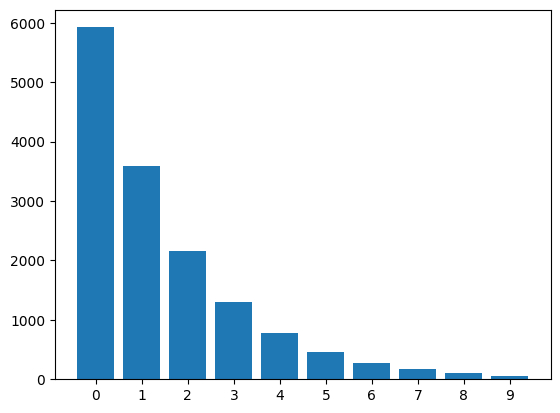

In [3]:
# create imbalanced data
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, **kwargs
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, **kwargs)

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

##Imbalance Dataset Without Sampler

In [5]:
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%" % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, "g")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", annot_kws={"size": 10})
    plt.show()
    return annot


def process(train_loader, test_loader, loss, epochs=20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = loss()

    def train(train_loader, loss):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(epochs):
        train(train_loader, loss)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

Best test acc = 49.67%
Best test acc = 64.78%
Best test acc = 70.71%
Best test acc = 72.62%
Best test acc = 73.48%
Best test acc = 75.00%
Best test acc = 75.97%
Best test acc = 76.53%
Best test acc = 77.80%
Best test acc = 78.19%
Best test acc = 81.01%
Best test acc = 81.57%
Best test acc = 82.64%
Best test acc = 85.49%
Best test acc = 85.49%
Best test acc = 87.20%
Best test acc = 87.20%
Best test acc = 88.01%
Best test acc = 88.58%
Best test acc = 88.90%


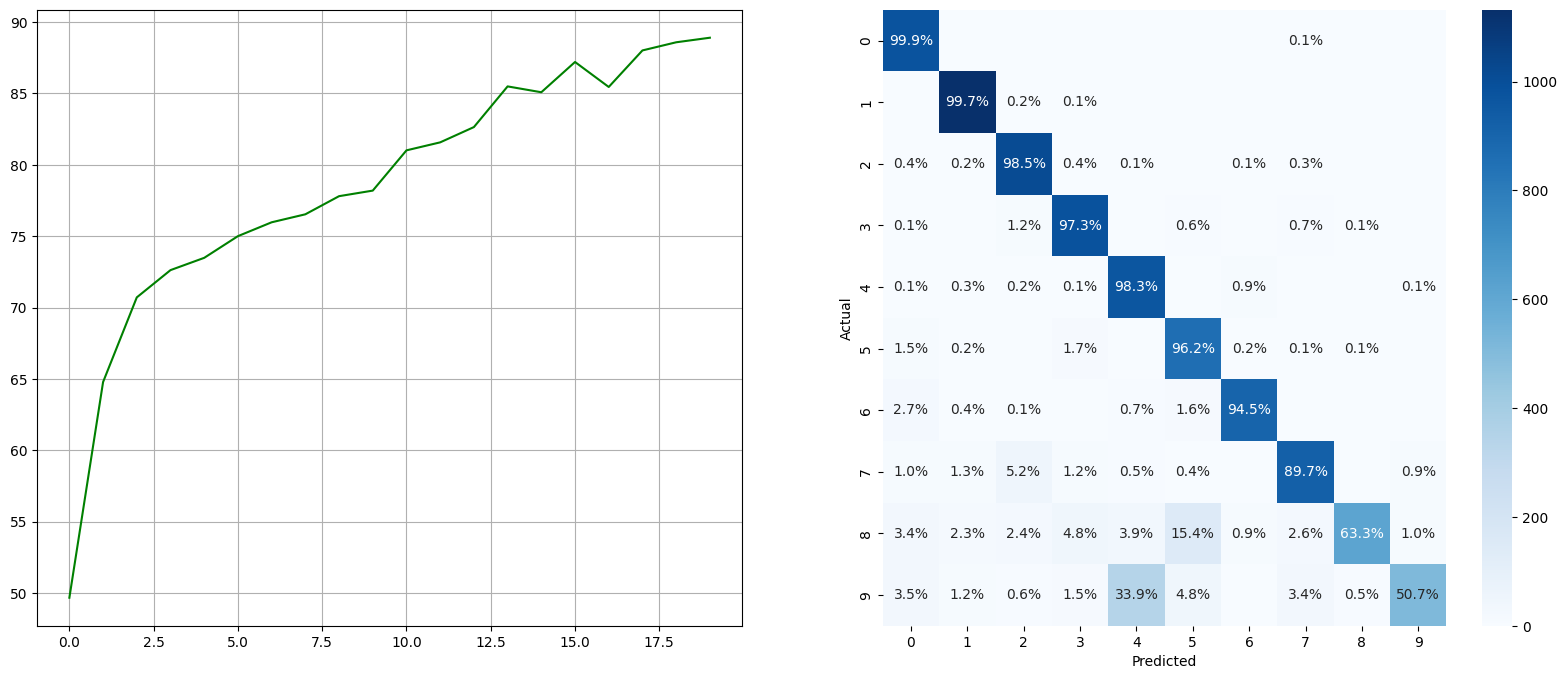

In [6]:
test_acc_baseline, baseline_percentages_per_class = process(
    imbalanced_train_loader, test_loader, torch.nn.NLLLoss, epochs=20
)

# Random oversampler

In [7]:
print(
    "imbalanced_train_loader.dataset.data.shape: ",
    imbalanced_train_loader.dataset.data.shape,
)
X = torch.stack(tuple(imbalanced_train_loader.dataset.data))
y = torch.tensor(imbalanced_train_loader.dataset.targets)

print(X.shape, y.shape)

imbalanced_train_loader.dataset.data.shape:  torch.Size([14809, 28, 28])
torch.Size([14809, 28, 28]) torch.Size([14809])


<ipython-input-7-80d9cbc601a9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(imbalanced_train_loader.dataset.targets)


In [8]:
reshaped_X = X.reshape(X.shape[0], -1)

# oversampling
oversampler = RandomOverSampler()
oversampled_X, oversampled_y = oversampler.fit_resample(reshaped_X, y)

# reshaping X back to the first dims
oversampled_X = oversampled_X.reshape(-1, 28, 28)
print(oversampled_X.shape)
print(oversampled_y.shape)

(59230, 28, 28)
(59230,)


Counter({0: 5923, 1: 5923, 3: 5923, 2: 5923, 7: 5923, 5: 5923, 6: 5923, 4: 5923, 9: 5923, 8: 5923})
Distribution of classes in oversampled dataset:


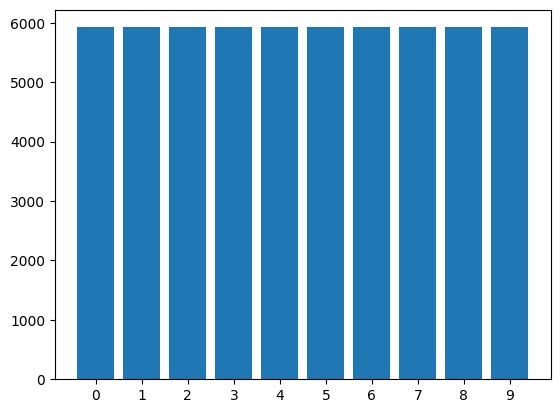

In [9]:
print(Counter(oversampled_y))

print("Distribution of classes in oversampled dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(oversampled_y, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [10]:
balanced_train_dataset = copy.deepcopy(imbalanced_train_dataset)
balanced_train_dataset.targets = torch.from_numpy(oversampled_y)
balanced_train_dataset.data = torch.from_numpy(oversampled_X)

balanced_train_loader = torch.utils.data.DataLoader(
    balanced_train_dataset, batch_size=100, shuffle=True
)

In [11]:
print(imbalanced_train_loader.dataset.data.shape)
print(imbalanced_train_loader.dataset.targets.shape)

torch.Size([14809, 28, 28])
torch.Size([14809])


In [12]:
print((balanced_train_loader.dataset.data.shape))
print((balanced_train_loader.dataset.targets.shape))
balanced_train_loader.batch_size

torch.Size([59230, 28, 28])
torch.Size([59230])


100

Best test acc = 92.52%
Best test acc = 94.68%
Best test acc = 95.29%
Best test acc = 95.69%
Best test acc = 96.15%
Best test acc = 96.16%
Best test acc = 96.18%
Best test acc = 96.44%
Best test acc = 96.44%
Best test acc = 96.49%
Best test acc = 96.56%
Best test acc = 96.56%
Best test acc = 96.61%
Best test acc = 96.61%
Best test acc = 96.81%
Best test acc = 96.81%
Best test acc = 96.81%
Best test acc = 96.81%
Best test acc = 96.81%
Best test acc = 96.81%


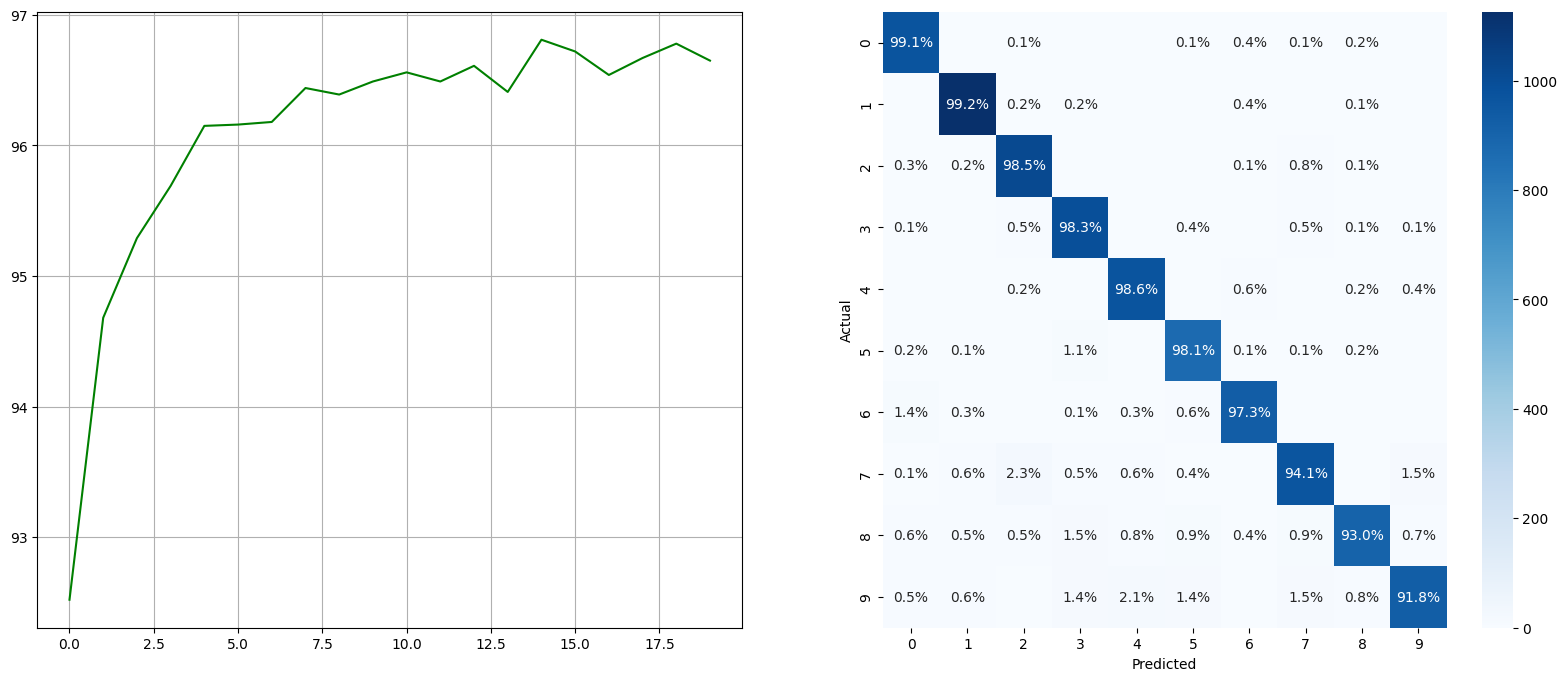

In [13]:
test_acc_ros, ros_percentages_per_class = process(
    balanced_train_loader, test_loader, torch.nn.NLLLoss, epochs=20
)

# Random undersampling

In [14]:
reshaped_X = X.reshape(X.shape[0], -1)

# oversampling
undersampler = RandomUnderSampler()
undersampled_X, undersampled_y = undersampler.fit_resample(reshaped_X, y)

# reshaping X back to the first dims
undersampled_X = undersampled_X.reshape(-1, 28, 28)
print(undersampled_X.shape)
print(undersampled_y.shape)

(600, 28, 28)
(600,)


Counter({0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60, 6: 60, 7: 60, 8: 60, 9: 60})
Distribution of classes in oversampled dataset:


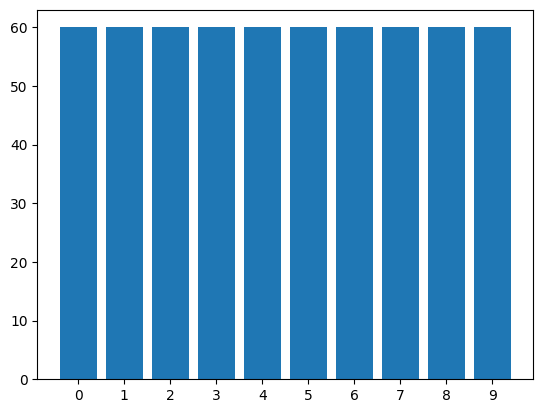

In [15]:
print(Counter(undersampled_y))

print("Distribution of classes in oversampled dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(undersampled_y, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [16]:
rus_balanced_train_dataset = copy.deepcopy(imbalanced_train_dataset)
rus_balanced_train_dataset.targets = torch.from_numpy(undersampled_y)
rus_balanced_train_dataset.data = torch.from_numpy(undersampled_X)

rus_balanced_train_loader = torch.utils.data.DataLoader(
    rus_balanced_train_dataset, batch_size=100, shuffle=True
)

### Before undersampling

In [17]:
print(imbalanced_train_loader.dataset.data.shape)
print(imbalanced_train_loader.dataset.targets.shape)

torch.Size([14809, 28, 28])
torch.Size([14809])


### After undersampling

In [18]:
print(rus_balanced_train_loader.dataset.data.shape)
print(rus_balanced_train_loader.dataset.targets.shape)
rus_balanced_train_loader.batch_size

torch.Size([600, 28, 28])
torch.Size([600])


100

Best test acc = 10.14%
Best test acc = 13.01%
Best test acc = 16.82%
Best test acc = 24.42%
Best test acc = 26.48%
Best test acc = 30.37%
Best test acc = 33.65%
Best test acc = 37.89%
Best test acc = 40.49%
Best test acc = 46.63%
Best test acc = 48.24%
Best test acc = 49.89%
Best test acc = 59.11%
Best test acc = 60.40%
Best test acc = 60.57%
Best test acc = 66.50%
Best test acc = 69.59%
Best test acc = 71.50%
Best test acc = 73.79%
Best test acc = 74.51%


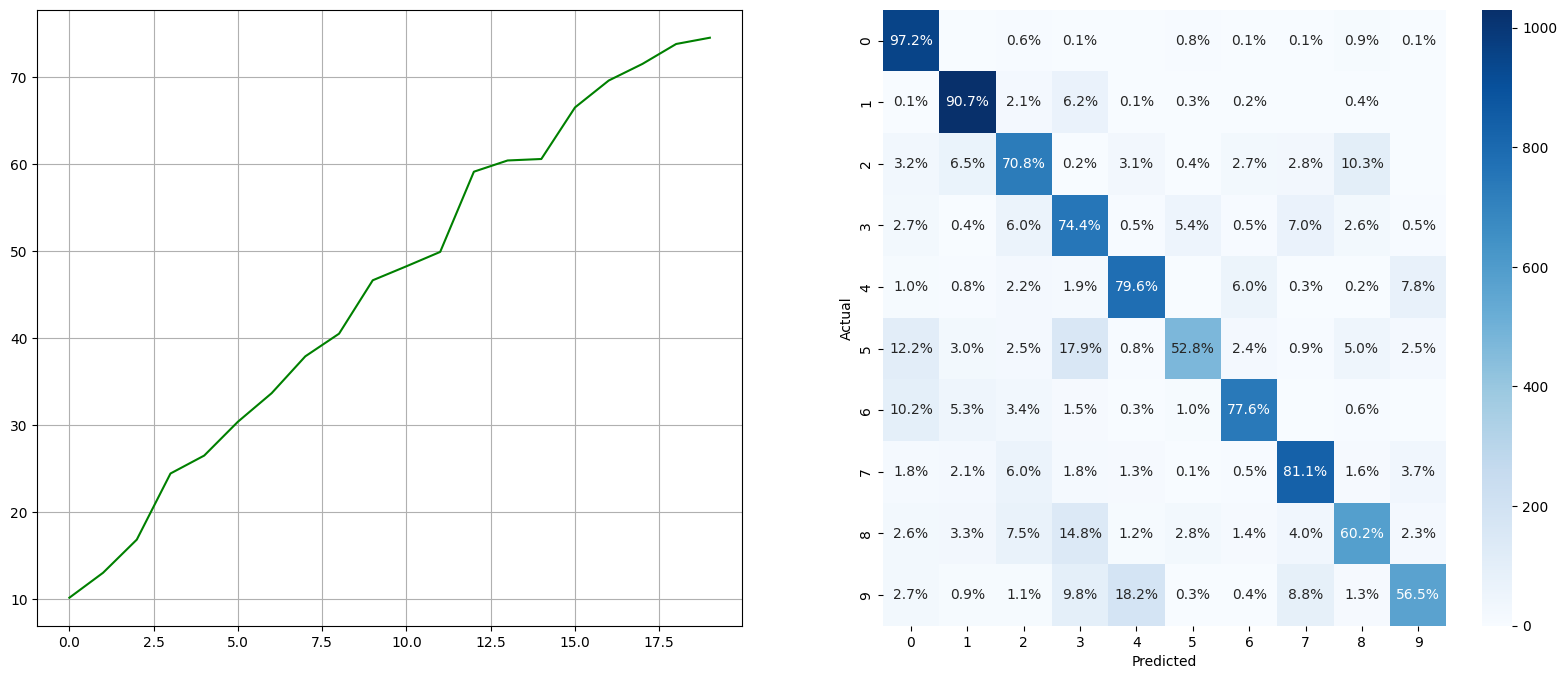

In [19]:
test_acc_rus, rus_percentages_per_class = process(
    rus_balanced_train_loader, test_loader, torch.nn.NLLLoss, epochs=20
)

In [20]:
ros_percentages_per_class

array([['99.1%', '', '0.1%', '', '', '0.1%', '0.4%', '0.1%', '0.2%', ''],
       ['', '99.2%', '0.2%', '0.2%', '', '', '0.4%', '', '0.1%', ''],
       ['0.3%', '0.2%', '98.5%', '', '', '', '0.1%', '0.8%', '0.1%', ''],
       ['0.1%', '', '0.5%', '98.3%', '', '0.4%', '', '0.5%', '0.1%',
        '0.1%'],
       ['', '', '0.2%', '', '98.6%', '', '0.6%', '', '0.2%', '0.4%'],
       ['0.2%', '0.1%', '', '1.1%', '', '98.1%', '0.1%', '0.1%', '0.2%',
        ''],
       ['1.4%', '0.3%', '', '0.1%', '0.3%', '0.6%', '97.3%', '', '', ''],
       ['0.1%', '0.6%', '2.3%', '0.5%', '0.6%', '0.4%', '', '94.1%', '',
        '1.5%'],
       ['0.6%', '0.5%', '0.5%', '1.5%', '0.8%', '0.9%', '0.4%', '0.9%',
        '93.0%', '0.7%'],
       ['0.5%', '0.6%', '', '1.4%', '2.1%', '1.4%', '', '1.5%', '0.8%',
        '91.8%']], dtype='<U21')

# WeightedRandomSampler - PyTorch

In [21]:
class_counts = pd.Series(imbalanced_train_loader.dataset.targets.numpy()).value_counts()
class_weights = 1.0 / class_counts
class_weights

0    0.000169
1    0.000278
2    0.000464
3    0.000774
4    0.001292
5    0.002155
6    0.003597
7    0.006024
8    0.010000
9    0.016667
dtype: float64

In [22]:
sample_wts = compute_sample_weight(
    class_weight="balanced", y=imbalanced_train_loader.dataset.targets.numpy()
)

In [23]:
len(sample_wts)

14809

In [24]:
weightedRandomSampler = WeightedRandomSampler(
    weights=sample_wts, num_samples=len(imbalanced_train_dataset), replacement=True
)
weightedRandomSampler_dataloader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=weightedRandomSampler, batch_size=64
)

Best test acc = 85.71%
Best test acc = 90.76%
Best test acc = 92.54%
Best test acc = 93.85%
Best test acc = 94.22%
Best test acc = 94.92%
Best test acc = 94.92%
Best test acc = 95.33%
Best test acc = 95.39%
Best test acc = 95.70%
Best test acc = 95.75%
Best test acc = 95.83%
Best test acc = 95.87%
Best test acc = 95.96%
Best test acc = 96.08%
Best test acc = 96.08%
Best test acc = 96.08%
Best test acc = 96.25%
Best test acc = 96.46%
Best test acc = 96.46%


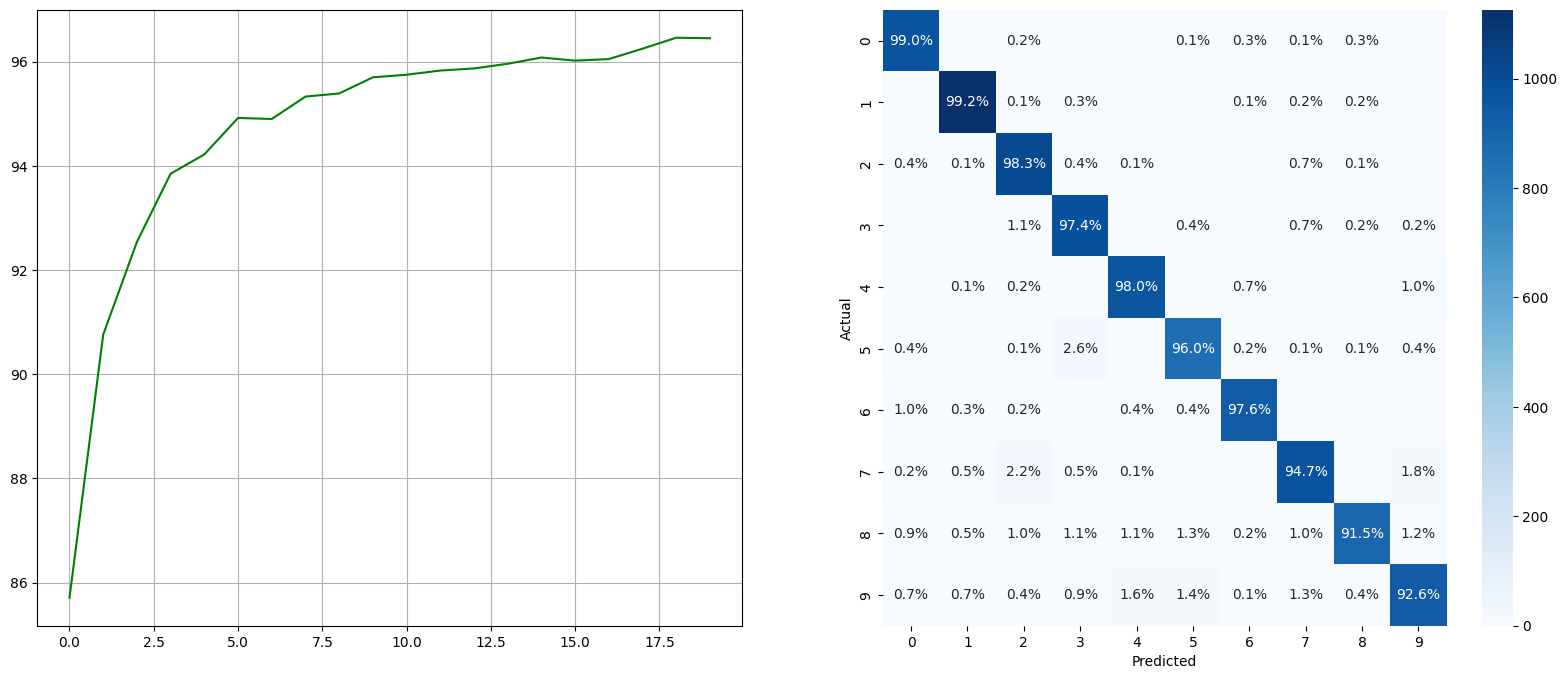

In [25]:
test_acc_weightedrandomsampler, weightedRandomSampler_percentages_per_class = process(
    weightedRandomSampler_dataloader, test_loader, torch.nn.NLLLoss, epochs=20
)

In [26]:
weightedRandomSampler_percentages_per_class

array([['99.0%', '', '0.2%', '', '', '0.1%', '0.3%', '0.1%', '0.3%', ''],
       ['', '99.2%', '0.1%', '0.3%', '', '', '0.1%', '0.2%', '0.2%', ''],
       ['0.4%', '0.1%', '98.3%', '0.4%', '0.1%', '', '', '0.7%', '0.1%',
        ''],
       ['', '', '1.1%', '97.4%', '', '0.4%', '', '0.7%', '0.2%', '0.2%'],
       ['', '0.1%', '0.2%', '', '98.0%', '', '0.7%', '', '', '1.0%'],
       ['0.4%', '', '0.1%', '2.6%', '', '96.0%', '0.2%', '0.1%', '0.1%',
        '0.4%'],
       ['1.0%', '0.3%', '0.2%', '', '0.4%', '0.4%', '97.6%', '', '', ''],
       ['0.2%', '0.5%', '2.2%', '0.5%', '0.1%', '', '', '94.7%', '',
        '1.8%'],
       ['0.9%', '0.5%', '1.0%', '1.1%', '1.1%', '1.3%', '0.2%', '1.0%',
        '91.5%', '1.2%'],
       ['0.7%', '0.7%', '0.4%', '0.9%', '1.6%', '1.4%', '0.1%', '1.3%',
        '0.4%', '92.6%']], dtype='<U21')

##Dynamic Sampling

In [27]:
# define a custom sampler
class DynamicSampler(torch.utils.data.sampler.Sampler):
    """Samples elements from a given list of indices with given probabilities (weights), with replacement.

    Arguments:
        weights (sequence)   : a sequence of weights, not necessary summing up to one
        num_samples (int): number of samples to draw
    """

    def __init__(self, indices, weights, num_samples=0):
        if isinstance(num_samples, bool):
            raise ValueError(
                "num_samples should be a non-negative integeral "
                "value, but got num_samples={}".format(num_samples)
            )
        self.indices = indices
        weights = [weights[i] for i in self.indices]
        self.weights = torch.tensor(weights, dtype=torch.double)
        if num_samples == 0:
            self.num_samples = len(self.weights)
        else:
            self.num_samples = num_samples
        self.replacement = True

    def __iter__(self):
        return (
            self.indices[i]
            for i in torch.multinomial(self.weights, self.num_samples, self.replacement)
        )

    def __len__(self):
        return self.num_samples

In [28]:
def create_model():
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    return model, optimizer


def train_model(model, optimizer, train_loader, loss_criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()


def evaluate_model(model, test_loader):
    model.eval()
    correct_predictions = 0
    targets = []
    outputs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct_predictions += pred.eq(target.view_as(pred)).sum().item()
            outputs.append(pred)
            targets.append(target)
    return correct_predictions, outputs, targets


def calculate_metrics(outputs, targets):
    outputs = torch.cat(outputs, 0).detach().cpu().numpy()
    targets = torch.cat(targets, 0).detach().cpu().numpy()
    cf = confusion_matrix(outputs, targets, labels=np.array(range(10)))

    precision = np.array([])
    recall = np.array([])
    for i in range(len(cf)):
        if np.sum(cf[i]) == 0:
            precision = np.append(precision, 1)
        else:
            precision = np.append(precision, cf[i][i] / np.sum(cf[i]))
        if np.sum(cf, axis=0)[i] == 0:
            recall = np.append(recall, 0)
        else:
            recall = np.append(recall, cf[i][i] / np.sum(cf, axis=0)[i])
    return precision, recall, cf


def calculate_weights(precision, recall, cf):
    f1_scores = np.zeros((len(cf)))
    for i in range(len(cf)):
        if precision[i] + recall[i] == 0:
            f1_scores[i] = 0
        else:
            f1_scores[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    weights = (1 - f1_scores) * 10 / (1 - f1_scores).sum()
    return weights


def process_sampler(train_dataset, test_dataset, loss, epochs=20):
    model, optimizer = create_model()
    loss_criterion = loss()

    test_accs, confusion_mtxes = [], []
    samples_weights = np.ones(len(train_dataset.targets))
    train_target_indexes = np.arange(0, len(train_dataset.targets), 1, dtype=int)
    for epoch in range(epochs):
        train_sampler = DynamicSampler(train_target_indexes, samples_weights)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, sampler=train_sampler, num_workers=0
        )

        train_model(model, optimizer, train_loader, loss_criterion)

        correct_predictions, outputs, targets = evaluate_model(model, test_loader)
        test_acc = 100.0 * correct_predictions / len(test_loader.dataset)
        test_accs.append(test_acc)

        precision, recall, confusion_mtx = calculate_metrics(outputs, targets)
        confusion_mtxes.append(confusion_mtx)

        weights = calculate_weights(precision, recall, confusion_mtx)

        for i in range(0, len(samples_weights)):
            samples_weights[i] = weights[train_dataset.targets[i]]

        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

Best test acc = 73.30%
Best test acc = 89.96%
Best test acc = 91.76%
Best test acc = 93.21%
Best test acc = 93.21%
Best test acc = 93.21%
Best test acc = 94.07%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.16%
Best test acc = 95.50%
Best test acc = 95.50%
Best test acc = 95.52%
Best test acc = 95.52%
Best test acc = 95.74%


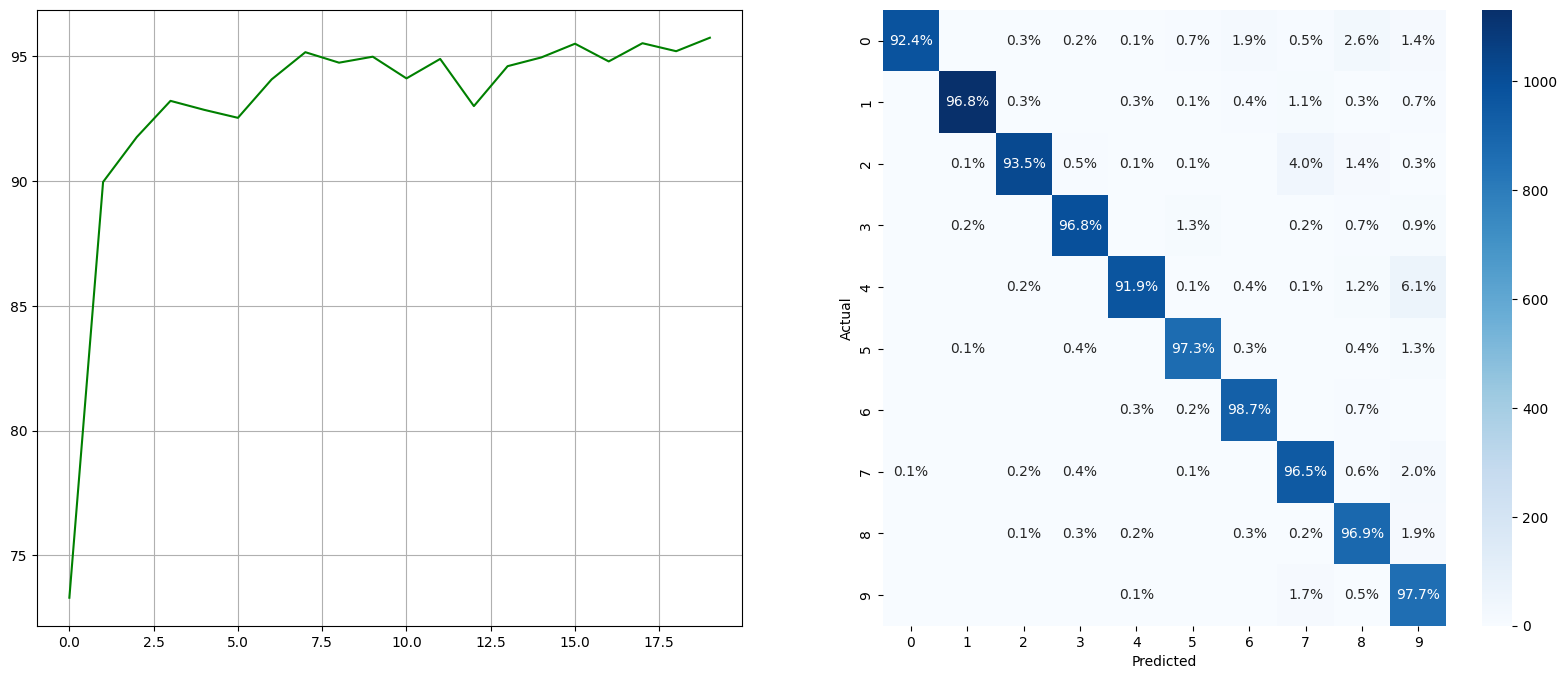

In [29]:
test_acc_dynamic_sampling, dynamic_sampling_percentages_per_class = process_sampler(
    imbalanced_train_dataset, test_loader, torch.nn.NLLLoss, epochs=20
)

# Baseline vs WeightedRandomSampler vs dynamic sampling

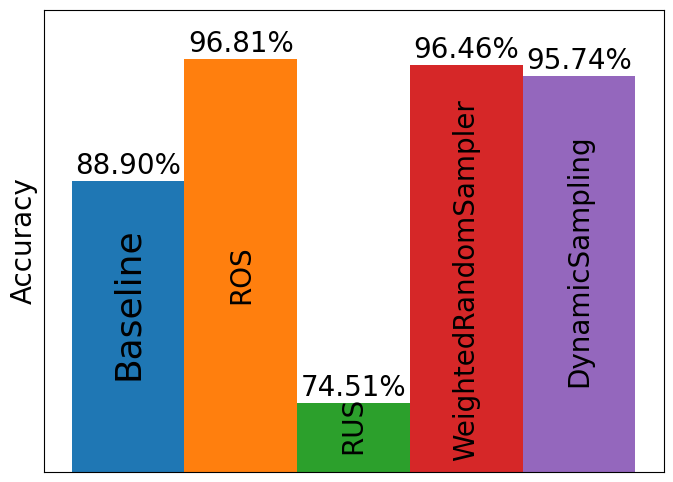

In [36]:
fig = plt.subplots(figsize=(8, 6))
plt.rcParams["font.size"] = 26

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]
br3 = [x + 0.1 for x in br2]
br4 = [x + 0.1 for x in br3]
br5 = [x + 0.1 for x in br4]


p1 = plt.bar(
    br1, np.array(test_acc_baseline).astype(float), width=0.1, label="Baseline"
)
p2 = plt.bar(br2, np.array(test_acc_ros).astype(float), width=0.1, label="ROS")
p3 = plt.bar(br3, np.array(test_acc_rus).astype(float), width=0.1, label="RUS")
p4 = plt.bar(
    br4,
    np.array(test_acc_weightedrandomsampler).astype(float),
    width=0.1,
    label="WeightedRandomSampler",
)
p5 = plt.bar(
    br5,
    np.array(test_acc_dynamic_sampling).astype(float),
    width=0.1,
    label="DynamicSampling",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=20,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 8,
        "Baseline",
        ha="center",
        va="center",
        rotation=90,
    )

for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=20,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 14,
        "ROS",
        ha="center",
        va="center",
        rotation=90,
        fontsize=20,
    )

for rect1 in p3:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=20,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 1.5,
        "RUS",
        ha="center",
        va="center",
        rotation=90,
        fontsize=20,
    )

for rect1 in p4:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=20,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 14,
        "WeightedRandomSampler",
        ha="center",
        va="center",
        rotation=90,
        fontsize=20,
    )

for rect1 in p5:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=20,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "DynamicSampling",
        ha="center",
        va="center",
        rotation=90,
        fontsize=20,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
# plt.legend(loc='lower right', fontsize=15)
plt.ylabel("Accuracy", fontsize=20)
plt.show()

In [37]:
print("Baseline model: ", np.diagonal(baseline_percentages_per_class))
print("Random Oversampling: ", np.diagonal(ros_percentages_per_class))
print("Random Undersampling: ", np.diagonal(rus_percentages_per_class))
print(
    "WeightedRandomSampler: ", np.diagonal(weightedRandomSampler_percentages_per_class)
)
print("Dynamic Sampling: ", np.diagonal(dynamic_sampling_percentages_per_class))

classes = np.arange(10)
list1 = np.diagonal(baseline_percentages_per_class)
list2 = np.diagonal(weightedRandomSampler_percentages_per_class)
list3 = np.diagonal(dynamic_sampling_percentages_per_class)
list4 = np.diagonal(ros_percentages_per_class)
list5 = np.diagonal(rus_percentages_per_class)

df = pd.DataFrame(
    {
        "Baseline": list1,
        "WeightedRandomSampler": list2,
        "DynamicSampler": list3,
        "Random Oversampling": list4,
        "Random Undersampling": list5,
    }
)
print(df)

Baseline model:  ['99.9%' '99.7%' '98.5%' '97.3%' '98.3%' '96.2%' '94.5%' '89.7%' '63.3%'
 '50.7%']
Random Oversampling:  ['99.1%' '99.2%' '98.5%' '98.3%' '98.6%' '98.1%' '97.3%' '94.1%' '93.0%'
 '91.8%']
Random Undersampling:  ['97.2%' '90.7%' '70.8%' '74.4%' '79.6%' '52.8%' '77.6%' '81.1%' '60.2%'
 '56.5%']
WeightedRandomSampler:  ['99.0%' '99.2%' '98.3%' '97.4%' '98.0%' '96.0%' '97.6%' '94.7%' '91.5%'
 '92.6%']
Dynamic Sampling:  ['92.4%' '96.8%' '93.5%' '96.8%' '91.9%' '97.3%' '98.7%' '96.5%' '96.9%'
 '97.7%']
  Baseline WeightedRandomSampler DynamicSampler Random Oversampling  \
0    99.9%                 99.0%          92.4%               99.1%   
1    99.7%                 99.2%          96.8%               99.2%   
2    98.5%                 98.3%          93.5%               98.5%   
3    97.3%                 97.4%          96.8%               98.3%   
4    98.3%                 98.0%          91.9%               98.6%   
5    96.2%                 96.0%          97.3%       

In [32]:
baseline_model = [float(i.rstrip("%")) for i in list1]
weighted_random_sampler = [float(i.rstrip("%")) for i in list2]
dynamic_sampling = [float(i.rstrip("%")) for i in list3]
ros = [float(i.rstrip("%")) for i in list4]
rus = [float(i.rstrip("%")) for i in list5]

In [33]:
new_df = pd.DataFrame(
    {
        "Baseline": baseline_model,
        "WeightedRandomSampler": weighted_random_sampler,
        "DynamicSampler": dynamic_sampling,
        "Random Oversampling": ros,
        "Random Undersampling": rus,
    }
)
new_df

,Baseline,WeightedRandomSampler,DynamicSampler,Random Oversampling,Random Undersampling
0,99.9,99.0,92.4,99.1,97.2
1,99.7,99.2,96.8,99.2,90.7
2,98.5,98.3,93.5,98.5,70.8
3,97.3,97.4,96.8,98.3,74.4
4,98.3,98.0,91.9,98.6,79.6
5,96.2,96.0,97.3,98.1,52.8
6,94.5,97.6,98.7,97.3,77.6
7,89.7,94.7,96.5,94.1,81.1
8,63.3,91.5,96.9,93.0,60.2
9,50.7,92.6,97.7,91.8,56.5


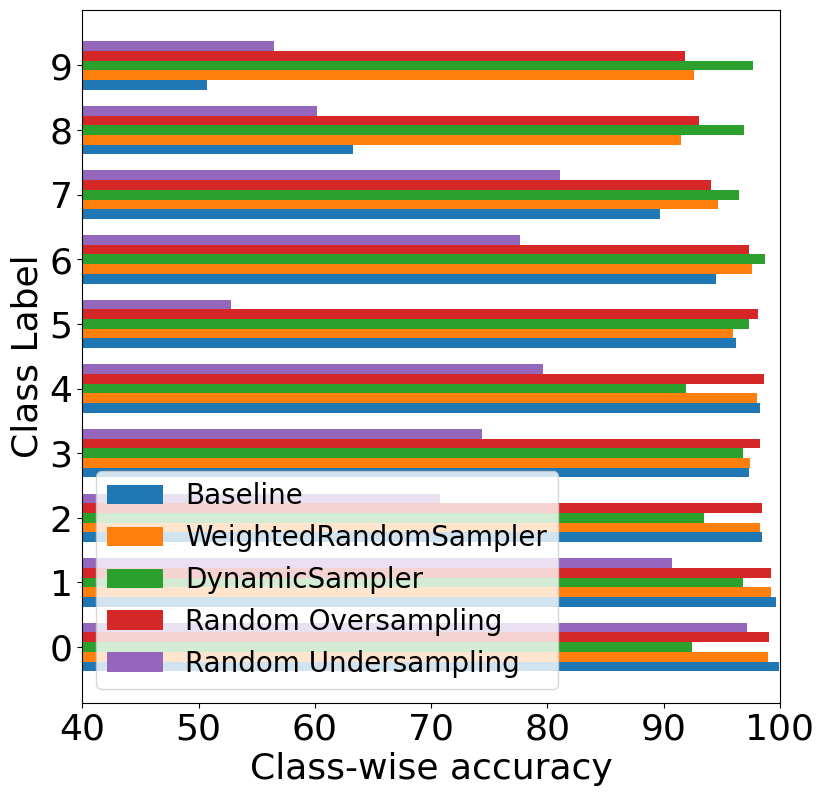

In [34]:
# Set the height of the bars
bar_height = 0.15

# Set the positions of the bars
r1 = np.arange(len(df["Baseline"]))
r2 = [x + bar_height for x in r1]
r3 = [x + bar_height for x in r2]
r4 = [x + bar_height for x in r3]
r5 = [x + bar_height for x in r4]

plt.figure(figsize=(9, 9))

# Create the bars with labels for the legend
bars1 = plt.barh(r1, new_df["Baseline"], height=bar_height, label="Baseline")
bars2 = plt.barh(
    r2,
    new_df["WeightedRandomSampler"],
    height=bar_height,
    label="WeightedRandomSampler",
)
bars3 = plt.barh(
    r3, new_df["DynamicSampler"], height=bar_height, label="DynamicSampler"
)
bars4 = plt.barh(
    r4, new_df["Random Oversampling"], height=bar_height, label="Random Oversampling"
)
bars5 = plt.barh(
    r5, new_df["Random Undersampling"], height=bar_height, label="Random Undersampling"
)

# Add labels and title
plt.ylabel("Class Label", fontsize=26)
plt.xlabel("Class-wise accuracy", fontsize=26)
plt.yticks(
    [r + bar_height * 2 for r in range(len(df["Baseline"]))], df.index, fontsize=26
)
plt.xlim(40, 100)

plt.legend(loc="lower left", fontsize=20)
plt.show()